In [1]:
!nvidia-smi

Sun Jan 30 10:53:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install plotting

In [3]:
import gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optimizer
import matplotlib.pyplot as plt
import base64, io, glob
from collections import deque, namedtuple
import plotting
import matplotlib 
import matplotlib.style
matplotlib.style.use('ggplot')

In [4]:
!pip3 install box2d-py
!pip3 install gym[Box_2D]
!pip3 install box2d-py
!pip3 install box2d-py==2.3.8
!pip install BOX2D
!pip install box2d
!pip install gym[BOX_2D]

     |████████████████████████████████| 448 kB 15.8 MB/s 
     |████████████████████████████████| 1.3 MB 11.2 MB/s 


In [5]:
from gym.envs.box2d.lunar_lander import LunarLander
env = gym.make("LunarLander-v2")
env.seed(0)

[0]

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##BUFFER

In [7]:
class ReplayExperienceBuffer():
    def __init__(self, n_action, buffer_size, seed):
        self.n_action = n_action
        self.storage = deque(maxlen=buffer_size)  
        self.batch_size = 32
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add_experience(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.storage.append(e)
    
    def sample(self):

        experiences = random.sample(self.storage, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.storage)

##َAGENT

In [16]:
class Agent():

    def __init__(self, state_size, n_action, seed):
        self.state_size = state_size
        self.n_action = n_action
        self.seed = random.seed(seed)

        self.qnetwork_local = DeepNetwork(state_size, n_action, seed).to(device)
        self.qnetwork_target = DeepNetwork(state_size, n_action, seed).to(device)
        self.optimizer = optimizer.Adam(self.qnetwork_local.parameters(), lr=5e-4)

        self.buffer = ReplayExperienceBuffer(n_action, int(1e2), seed)
        
        self.time_step = 0
    
    def step(self, state, action, reward, next_state, done):
        self.buffer.add_experience(state, action, reward, next_state, done)
        self.time_step = (self.time_step + 1) % 4
        if self.time_step == 0:
            if len(self.buffer) > 32:
                experiences = self.buffer.sample()
                self.learn(experiences, 0.99)

    def choose_action(self, state, epsilon=0):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.n_action))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        loss = functional.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.update_target_network(self.qnetwork_local, self.qnetwork_target, 1e-3)                     

    def update_target_network(self, local_model, target_model, t):
      
        for target, local in zip(target_model.parameters(), local_model.parameters()):
            target.data.copy_(t*local.data + (1.0-t)*target.data)


##DEEP

In [17]:
class DeepNetwork(nn.Module):
  
    def __init__(self, n_state, n_action, seed):
        
        super(DeepNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.l1 = nn.Linear(n_state, 32)
        self.l2 = nn.Linear(32, 32)
        self.l3 = nn.Linear(32, n_action)
        
    def forward(self, state):
        x = self.l1(state)
        x = functional.relu(x)
        x = self.l2(x)
        x = functional.relu(x)
        return self.l3(x)


##DQN

In [18]:
def dqn():

    REWARDS = []                        
    sliding_window = deque(maxlen=100)  
    epsilon = 1                    
    for iter in range(1, 1001):
        state = env.reset()
        rew = 0
        for t in range(1000):
            action = agent.choose_action(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            rew += reward
            if done:
                break 
        sliding_window.append(rew)       
        REWARDS.append(rew)              
        epsilon = max(0.01, 0.995*epsilon) 
        if iter % 100 == 0:
            print('episode', iter, 'Average Reward:', np.mean(sliding_window))

    return REWARDS, sliding_window



##PLOT

episode 100 Average Reward: -194.20646742901314
episode 200 Average Reward: -179.71042967377645
episode 300 Average Reward: -146.43186793551385
episode 400 Average Reward: -76.79291713148338
episode 500 Average Reward: 51.16365888972134
episode 600 Average Reward: -64.03923712671867
episode 700 Average Reward: -82.70185289505427
episode 800 Average Reward: -106.17165249219103
episode 900 Average Reward: -124.37077058209371
episode 1000 Average Reward: -113.46101317506094


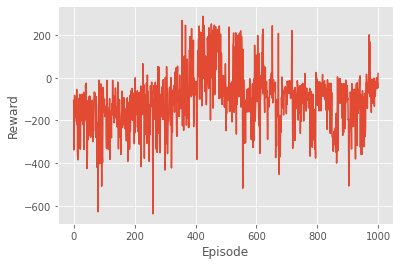

In [19]:
agent = Agent(state_size=8, n_action=4, seed=0)
REWARDS, avg_reward = dqn()
fig = plt.figure()
plt.plot(np.arange(len(REWARDS)), REWARDS)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()